<a href="https://www.kaggle.com/code/sjain600/baseline-model-with-lightbm?scriptVersionId=233403402" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

In [3]:
train.shape

(1200000, 21)

In [4]:
test.shape

(800000, 20)

In [5]:
train.sample(10)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
381844,381844,58.0,Female,24466.0,Divorced,3.0,Master's,<NA>,49.74947108,Suburban,Comprehensive,1.0,11.0,619.0,9.0,2022-11-04 15:21:39.150730,Average,Yes,Monthly,Apartment,1308.0
402129,402129,50.0,Male,31050.0,Single,1.0,Master's,<NA>,6.923844706,Urban,Premium,0.0,2.0,805.0,7.0,2023-08-21 15:21:39.096739,Poor,Yes,Monthly,Apartment,1440.0
420058,420058,22.0,Female,55475.0,Single,4.0,Master's,Unemployed,<NA>,Urban,Premium,0.0,1.0,470.0,5.0,2020-10-20 15:21:39.198406,<NA>,No,Weekly,Condo,1520.0
746688,746688,56.0,Male,3451.0,<NA>,2.0,High School,Self-Employed,15.83976218,Urban,Basic,<NA>,1.0,755.0,7.0,2024-02-05 15:21:39.192212,Good,Yes,Weekly,Condo,749.0
502572,502572,59.0,Female,36454.0,Single,1.0,Bachelor's,Employed,<NA>,Rural,Comprehensive,<NA>,17.0,583.0,4.0,2020-10-30 15:21:39.110557,Poor,No,Monthly,Apartment,28.0
284644,284644,45.0,Male,26011.0,Single,4.0,Master's,Employed,24.73785443,Suburban,Comprehensive,<NA>,8.0,766.0,9.0,2020-04-14 15:21:39.084065,Good,No,Weekly,Condo,1879.0
694834,694834,23.0,Female,27963.0,Divorced,0.0,PhD,<NA>,15.90868299,Suburban,Comprehensive,<NA>,7.0,607.0,2.0,2022-06-20 15:21:39.289099,Good,Yes,Daily,Apartment,1414.0
655693,655693,61.0,Male,857.0,Married,1.0,High School,Employed,41.95590046,Rural,Basic,<NA>,6.0,467.0,5.0,2023-11-30 15:21:39.126661,Average,No,Monthly,Condo,901.0
1135129,1135129,59.0,Male,44667.0,Single,1.0,PhD,Unemployed,45.7850664,Rural,Basic,0.0,9.0,718.0,4.0,2024-08-04 15:21:39.199447,Good,No,Daily,House,662.0
884811,884811,43.0,Female,44768.0,Married,4.0,Bachelor's,Unemployed,52.08547617,Suburban,Premium,2.0,17.0,586.0,5.0,2021-09-01 15:21:39.186212,<NA>,Yes,Rarely,Apartment,1733.0


In [6]:
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
train['year'] = train['Policy Start Date'].dt.year.astype('float32')
train['month'] = train['Policy Start Date'].dt.month.astype('float32')
train['day'] = train['Policy Start Date'].dt.day.astype('float32')
train['day_of_week'] = train['Policy Start Date'].dt.day_of_week.astype('float32')
train['seconds'] = (train['Policy Start Date'].astype(int) // 10**9).astype('float32')
train.drop('Policy Start Date', axis=1, inplace=True)

In [7]:
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])
test['year'] = test['Policy Start Date'].dt.year.astype('float32')
test['month'] = test['Policy Start Date'].dt.month.astype('float32')
test['day'] = test['Policy Start Date'].dt.day.astype('float32')
test['day_of_week'] = test['Policy Start Date'].dt.day_of_week.astype('float32')
test['seconds'] = (test['Policy Start Date'].astype(int) // 10**9).astype('float32')
test.drop('Policy Start Date', axis=1, inplace=True)

## EDA

In [8]:
train.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
year                         0
month                        0
day                          0
day_of_week                  0
seconds                      0
dtype: int64

In [9]:
test.isnull().sum()

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
year                         0
month                        0
day                          0
day_of_week                  0
seconds                      0
dtype: int64

In [10]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   id                    1200000 non-null  int64
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object
 7   Occupation            841925 non-null   object
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object
 10  Policy Type           1200000 non-null  object
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-null  floa

## Converting object dtype into category for faster processing

In [11]:
cat_cols = train.select_dtypes(include='object').columns
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [12]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   id                    1200000 non-null  int64
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  category
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  category
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  category
 7   Occupation            841925 non-null   category
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  category
 10  Policy Type           1200000 non-null  category
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 no

## Data Preprocessing

In [13]:
from sklearn.impute import SimpleImputer

simple = SimpleImputer(strategy='most_frequent')
cat_cols = train.select_dtypes(include='category').columns
train[cat_cols] = simple.fit_transform(train[cat_cols])
test[cat_cols] = simple.transform(test[cat_cols])

In [14]:
from category_encoders import CountEncoder

ce = CountEncoder()
train[cat_cols] = ce.fit_transform(train[cat_cols])
test[cat_cols] = ce.transform(test[cat_cols])

In [15]:
simple = SimpleImputer(strategy='median')
num_cols = test.select_dtypes(exclude='object').columns
train[num_cols] = simple.fit_transform(train[num_cols])
test[num_cols] = simple.transform(test[num_cols])

## Feature engineering

In [16]:
def add_features(df):
    df['income_oocupation'] = df['Annual Income'] * df['Occupation']
    df['education_occupation'] = df['Education Level'] * df['Occupation']
    df['education_income'] = df['Education Level'] * df['Annual Income']
    df['location_income'] = df['Location'] * df['Annual Income']
    df['location_property'] = df['Location'] * df['Property Type']
    df['martial_dependents'] = df['Marital Status'] * df['Number of Dependents']
    df['income_credit'] = df['Annual Income'] * df['Credit Score']
    df['income_policy'] = df['Annual Income'] * df['Policy Type']
    df['health_exercise'] = df['Health Score'] * df['Exercise Frequency']
    df['policy_claims'] = df['Policy Type'] * df['Previous Claims']
    df['policy_occupation'] = df['Policy Type'] * df['Occupation']
    
    return df

## Identifying outliers

<Axes: ylabel='Premium Amount'>

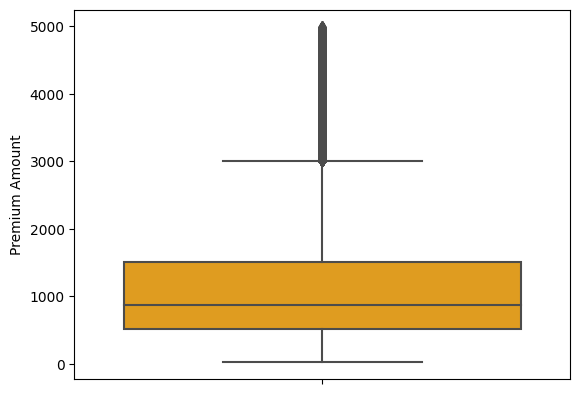

In [17]:
sns.boxplot(data=train, y='Premium Amount', color='orange')

## Splitting the data for model prediction

In [18]:
from sklearn.model_selection import KFold

X = train.copy()
y = X.pop('Premium Amount')
X = add_features(X)
y = np.log(y)

X_test = test.copy()
X_test = add_features(X_test)

kf = KFold(n_splits=10, random_state=340, shuffle=True)
for train_index, valid_index in kf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    

## LightGBM

In [19]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

lgm = LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.06738100925889774, 
    min_split_gain=4.708741923911547,
    max_depth=13, 
    reg_lambda=2.082992538887048, 
    feature_fraction=0.796395105708553,
    random_state=340, 
    n_jobs= -1,
    device_type='gpu',
    verbose=-1
).fit(X_train, y_train)

preds_light = lgm.predict(X_valid)
print(f'RMSLE: {np.sqrt(mean_squared_log_error(preds_light, y_valid)):,.5f}')

RMSLE: 0.16047


## Submission

In [20]:
test_preds = lgm.predict(X_test)
sub = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
sub['Premium Amount'] = np.exp(test_preds) - 1
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
sub.head()

Your submission was successfully saved!


,id,Premium Amount
0,1200000,643.974906
1,1200001,797.906688
2,1200002,812.080483
3,1200003,791.884519
4,1200004,771.858660
